In [1]:
# setup django project in jupiter
from django_for_jupyter import init_django
init_django("dpm_env")

In [2]:
# libraries
import requests as req
from django.urls import reverse
import json
from accounts import views as account_view
from project import views as project_view
from project_charter import views as project_charter_view
from project_budget import views as project_budget_view
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# user login details
user_pmo = {"email": "pmo@email.com", "password": "pmo12345"}
user_pm  = {"email": "pm@email.com", "password": "pm123456"}

In [28]:
# http requests
base_url = "http://localhost:8000"

def post_request(data, route, auth_token=None, path_param=None, type_json=False):
    headers = {}
    if path_param:
        path = reverse(route, None, {path_param})
    else:
        path = reverse(route)
    if type_json:
        headers = dict(headers, **{'Content-Type': 'application/json'})
    if auth_token:
        headers = dict(headers, **{'Authorization': f'token {auth_token}'})
    if isinstance(data, list):
        data = json.dumps(data)
    url = base_url + path
    
    return req.post(url, headers=headers, data=data)


def get_request(route, auth_token=None, path_param=None):
    headers = {}
    if path_param:
        path = reverse(route, None, {path_param})
    else:
        path = reverse(route)
    if auth_token:
        headers = {'Authorization': f'token {auth_token}'}
    url = base_url + path
    
    return req.get(url, headers=headers)

In [29]:
# login api
route = account_view.LoginAPI.name
response = post_request(data=user_pmo, route=route).json()
stakeholder_pmo = response.get('user')
token_pmo = response.get('auth_token')

response = post_request(data=user_pm, route=route).json()
stakeholder_pm = response.get('user')
token_pm = response.get('auth_token')

df = pd.json_normalize([stakeholder_pmo, stakeholder_pm])
df

,id,first_name,last_name,email,user_role,is_active
0,9,Luca,Verdi,pmo@email.com,PMO,True
1,11,Antonio,Bruno,pm@email.com,PM,True


In [30]:
# create a new project as PMO
author = stakeholder_pmo.get('id')
project = {
    "project_name": "Tesi Ranno",
    "author": author
}

route = project_view.ProjectAPI.name
response = post_request(data=project, route=route, auth_token=token_pmo).json()
result = response.get('detail')
result_project = response.get('project')

print("Result: ", result)
print("Project:")
result_project.pop('project_charter')

df = pd.json_normalize(result_project)
df

Result:  Project created successfully.
Project:


,id,project_name,author,created
0,82,Tesi Ranno,9,2022-04-26T15:10:23.251380Z


In [31]:
# prepare project charter as PM
project = result_project.get('id')
author = stakeholder_pm.get('id')
project_charter = {
    "project": project,
    "author": author,
    "sow": "standard thesis outline",
    "contract": "Guida Studente DIGEP per la tesi",
    "business_case": "Research Case Digital PM"
}

route = project_charter_view.ProjectCharterAPI.name
response = post_request(data=project_charter, route=route, auth_token=token_pm).json()
result = response.get('detail')
result_project_charter = response.get('project_charter')

print("Result: ", result)
print("Project_Charter:")
result_project_charter.pop('bus_case_swot')
result_project_charter.pop('project_budget')

df = pd.json_normalize(result_project_charter)
df

Result:  Project charter created successfully.
Project_Charter:


,id,project,author,created,last_updated,sow,contract,business_case
0,56,82,11,2022-04-26T15:10:26.491175Z,2022-04-26T15:10:26.491175Z,standard thesis outline,Guida Studente DIGEP per la tesi,Research Case Digital PM


In [32]:
# Add BusCase SWOT
project_charter = result_project_charter.get('id')

# swot 1
swot = {
    "project_charter": project_charter,
    "swot_type": "opportunity",
    "content": "Very small legacy in PIMS"
}

route = project_charter_view.BusinessCaseSWOTAPI.name
response = post_request(data=swot, route=route, auth_token=token_pm).json()
result = response.get('detail')
result_swot = response.get('swot')

result_swot.pop('project_charter')
result_swot.pop('id')
data = [result_swot]

# swot2
swot = {
    "project_charter": project_charter,
    "swot_type": "opportunity",
    "content": "A standard for PM exists"
}

response = post_request(data=swot, route=route, auth_token=token_pm).json()
result = response.get('detail')
result_swot = response.get('swot')

result_swot.pop('project_charter')
result_swot.pop('id')
data.append(result_swot)

# swot 3
swot = {
    "project_charter": project_charter,
    "swot_type": "weakness",
    "content": "Front ends must be custom built according to corporate paractices and back end constraints"
}

response = post_request(data=swot, route=route, auth_token=token_pm).json()
result = response.get('detail')
result_swot = response.get('swot')

print("Result: ", result)
result_swot.pop('project_charter')
result_swot.pop('id')
data.append(result_swot)

df = pd.json_normalize(data)
df

Result:  Business case swot added successfully.


,swot_type,content
0,opportunity,Very small legacy in PIMS
1,opportunity,A standard for PM exists
2,weakness,Front ends must be custom built according to c...


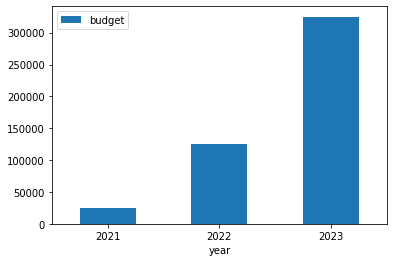

In [33]:
# Allocate project budget
budget = [{"year": 2021, "budget": 25000}, {"year": 2022, "budget": 125000}, {"year": 2023, "budget": 325000}]

route = project_budget_view.ProjectBudgetAPI.name
response = post_request(data=budget, route=route, auth_token=token_pm, path_param=project_charter, type_json=True).json()

years = []
budgets = []
for elem in response:
    years.append(elem.get('year')) 
    budgets.append(elem.get('budget'))

df = pd.DataFrame({'year': years, 'budget': budgets})
ax = df.plot.bar(x='year', y='budget', rot=0)

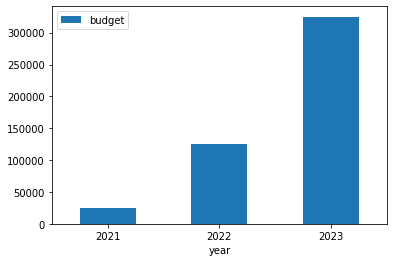

In [34]:
# Allocated budget
route = project_view.ProjectDetailsAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=project).json()
budget = response.get('project_charter').get('project_budget')

years = []
budgets = []
for elem in budget:
    years.append(elem.get('year')) 
    budgets.append(elem.get('budget'))

df = pd.DataFrame({'year': years, 'budget': budgets})
ax = df.plot.bar(x='year', y='budget', rot=0)